In [1]:
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import osmnx as ox

In [2]:
def search_information_matrix(M_prob_shortest_path):
    #Search information for each pair of nodes
    S = (-1) * np.log2(M_prob_shortest_path)

    return S

<h2>Get map graph</h2>

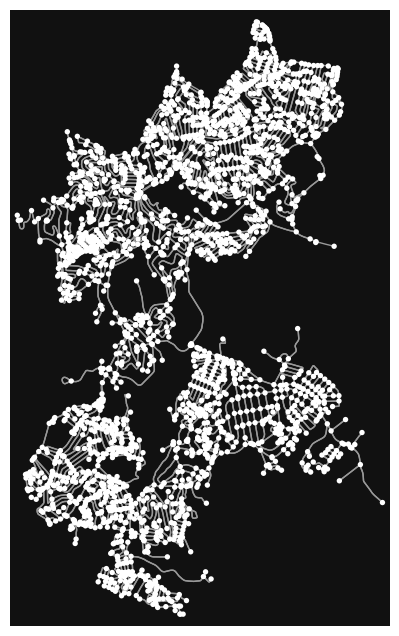

In [3]:
places = ['Jardim Ângela, São Paulo, Brazil']

graphs = []
# stats = {}
for place in places:
    graphs.append(ox.graph_from_place(place, network_type='drive'))
    # stats[place] = ox.basic_stats(G)
# print(pd.DataFrame(stats).T)

fig, ax = ox.plot_graph(graphs[0])

<h2>Convert graph edges to nodes</h2>

In [14]:
graph = graphs[0]

edge_list = list(graph.edges())



new_graph = nx.graph.Graph()

visited_nodes = []

print(new_graph.nodes())

def edge_to_node(graph, new_graph, node_u, node_v):
    try:
        edge_name = graph[node_u][node_v][0]['name']
    except Exception as error:
        return None, None
        # print(graph[edge[0]][edge[1]][0])
    
    is_list = type(edge_name) == list

    if(is_list):
        for name in edge_name:
            new_graph.add_node(name)
    else:
        new_graph.add_node(edge_name)

    return edge_name, is_list

def add_edges(graph, new_graph, new_node_name, node_u, node_v):
    edge_name, is_list = edge_to_node(graph, new_graph, node_u, node_v)

    if edge_name is None:
        return

    if(is_list):
        for name in edge_name:
            new_graph.add_edge(new_node_name, name)
    else:
        new_graph.add_edge(new_node_name, edge_name)

for edge in edge_list:
    # Converting edge to node
    edge_name, is_list = edge_to_node(graph, new_graph, edge[0], edge[1])

    if edge_name is None:
        continue

    # Adding edges
    for node in edge:
        connected_nodes = graph[node]

        for connected_node in connected_nodes:
            if(is_list):
                for name in edge_name:
                    add_edges(graph, new_graph, name, node, connected_node)
            else:
                add_edges(graph, new_graph, edge_name, node, connected_node)
            

new_graph.remove_edges_from(nx.selfloop_edges(new_graph))

nodes = max(nx.connected_components(new_graph), key=len)
new_graph = nx.subgraph(new_graph, nodes)

print(new_graph)

[]
Graph with 929 nodes and 1687 edges


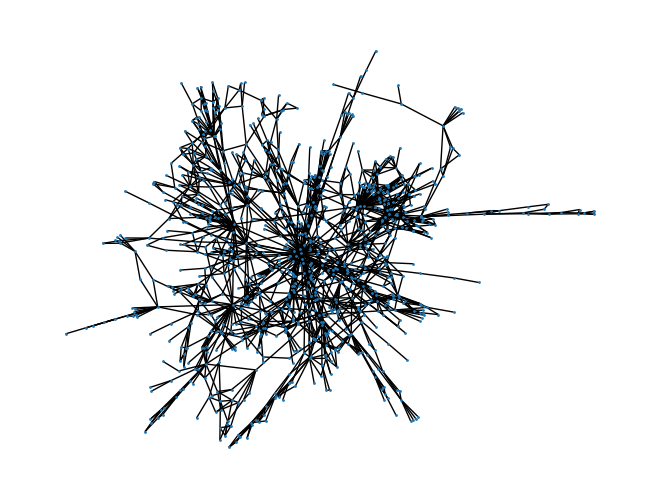

In [15]:
pos = nx.spring_layout(new_graph)
nx.draw(new_graph, pos=pos, node_size=1)

<h2>Get shortest path matrix</h2>

In [16]:
def probability_shortest_path_matrix(graph):

  N = len(graph)
  M_prob_shortest_path = np.zeros((N,N))
  # all shortest paths
  nodes = list(graph.nodes)
  TPs = []

  for s in nodes: # start node
    nodes_except_s = nodes.copy()
    nodes_except_s.remove(s)

    for t in nodes_except_s: # end node
      ks = graph.degree[s] # grau de s
      kt = graph.degree[t] # grau de t

      # optimization: already have 't' to 's' probability_path
      if M_prob_shortest_path[t-1][s-1] > 1e10:
        M_prob_shortest_path[s-1][t-1] = ks * (1/kt) * M_prob_shortest_path[t-1][s-1]
        break

      paths_i_j = list(nx.all_shortest_paths(graph,s,t))

      TP = 0 # total probabilitie to follow any shortest path

      ks = graph.degree[s] # grau de s

      for path in paths_i_j: # for each shortest path
        # probabilitie to follow each path
        P = 1/ks

        for j in path: # for each node 'j' in the way
          kj = graph.degree[j]
          # if that node has mode than one neighbor
          if kj > 1:
            P *= 1/(kj - 1)

        TP += P

      M_prob_shortest_path[s-1][t-1] = TP

  np.fill_diagonal(M_prob_shortest_path,1) # Probability to go from node to itself is 1 

  return M_prob_shortest_path

In [19]:
new_graph = nx.convert_node_labels_to_integers(new_graph)
graph_prob_shortest_path = probability_shortest_path_matrix(new_graph)

<h2>Get search information matrix</h2>

In [20]:
new_graph_search_information_matrix = search_information_matrix(graph_prob_shortest_path)
new_graph_search_information_matrix

array([[-0.        , 14.33620223, 14.62570884, ..., 23.98273752,
        21.11756194, 14.21067134],
       [10.01427413, -0.        ,  7.82552795, ..., 21.3713028 ,
        18.50612723,  5.169925  ],
       [10.62570884,  8.14745605, -0.        , ..., 21.98273752,
        19.11756194,  7.39890675],
       ...,
       [17.66080942, 19.3713028 , 19.66080942, ..., -0.        ,
        19.84888177, 19.24577192],
       [14.79563384, 16.50612723, 16.79563384, ..., 19.84888177,
        -0.        , 16.38059635],
       [ 9.88874325,  5.169925  ,  7.07697866, ..., 21.24577192,
        18.38059635, -0.        ]])

<h2>Get mean search information</h2>

In [21]:
new_graph_average_search_information = np.mean(new_graph_search_information_matrix)
new_graph_average_search_information

18.849127011827353